### Importing Libraries

In [1]:
!pip install xgboost

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz

### Preprocessing and EDA

In [3]:
#link to dataset -> https://www.kaggle.com/datasets/amanindiamuz/financial-dataset-for-fraud-detection-in-a-comapny
filename='Fraud.csv'

In [4]:
df=pd.read_csv(filename)
df.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


#### With the type of transactions, let's calculate the number of frauds with respect to the categories. 


In [37]:
df.groupby(["type","isFraud"]).count()['step']

type      isFraud
CASH_IN   0          1399284
CASH_OUT  0          2233384
          1             4116
DEBIT     0            41432
PAYMENT   0          2151495
TRANSFER  0           528812
          1             4097
Name: step, dtype: int64

#### Data Cleaning

In [7]:
# dropping irrelevant features
df_new=df.drop(columns=['nameOrig','nameDest','isFlaggedFraud'],axis=1)
df_new.head(5)

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


In [8]:
df_new.columns

Index(['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest', 'isFraud'],
      dtype='object')

In [47]:
!pip install plotly

  Obtaining dependency information for plotly from https://files.pythonhosted.org/packages/26/5d/1e13b597ed8e54803e9ac6ded18c04cd35d8cbc49016778ec50c4ca9e9d5/plotly-5.16.1-py2.py3-none-any.whl.metadata
  Obtaining dependency information for tenacity>=6.2.0 from https://files.pythonhosted.org/packages/f4/f1/990741d5bb2487d529d20a433210ffa136a367751e454214013b441c4575/tenacity-8.2.3-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/15.6 MB ? eta -:--:--
   ---------------------------------------- 0.1/15.6 MB 2.8 MB/s eta 0:00:06
    --------------------------------------- 0.3/15.6 MB 3.2 MB/s eta 0:00:05
   - -------------------------------------- 0.6/15.6 MB 3.9 MB/s eta 0:00:04
   -- ------------------------------------- 0.8/15.6 MB 4.5 MB/s eta 0:00:04
   -- ------------------------------------- 1.1/15.6 MB 4.5 MB/s eta 0:00:04
   --- ------------------------------------ 1.4/15.6 MB 4.9 MB/s eta 0:00:03
   ---- ----------------------------------- 1.6/15.6 MB 4.

In [50]:
X

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
2,1,1,181.00,181.00,0.0,0.00,0.00
3,1,0,181.00,181.00,0.0,21182.00,0.00
15,1,0,229133.94,15325.00,0.0,5083.00,51513.44
19,1,1,215310.30,705.00,0.0,22425.00,0.00
24,1,1,311685.89,10835.00,0.0,6267.00,2719172.89
...,...,...,...,...,...,...,...
6362615,743,0,339682.13,339682.13,0.0,0.00,339682.13
6362616,743,1,6311409.28,6311409.28,0.0,0.00,0.00
6362617,743,0,6311409.28,6311409.28,0.0,68488.84,6379898.11
6362618,743,1,850002.52,850002.52,0.0,0.00,0.00


#### class imbalance

In [63]:
# percentage above the bar
import seaborn as sb
def percent(ax,size):
  for patch in ax.patches:
    height = patch.get_height() # Figure height (number of data)
    width = patch.get_width() # Figure width
    x = patch.get_x() # The x-axis position on the left edge of the figure
    y = patch.get_y() 
    
    percent=(height/size)*10
    # Type text in the (x, y) coordinates
    ax.text(x+width/2,
        y+height*1.01,
            #s=f'{percent:1.1f}%', # Text
            s=f'{percent:1.1f}%',
            ha='center')

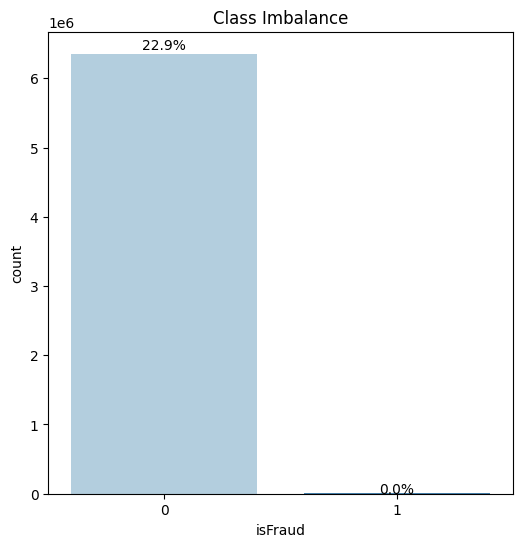

In [64]:
fig=plt.figure(figsize=(6,6))
ax=sb.countplot(x='isFraud',data=df,palette='Blues')
ax.set_title('Class Imbalance')
percent(ax,X.shape[0])

plt.show()

In [71]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


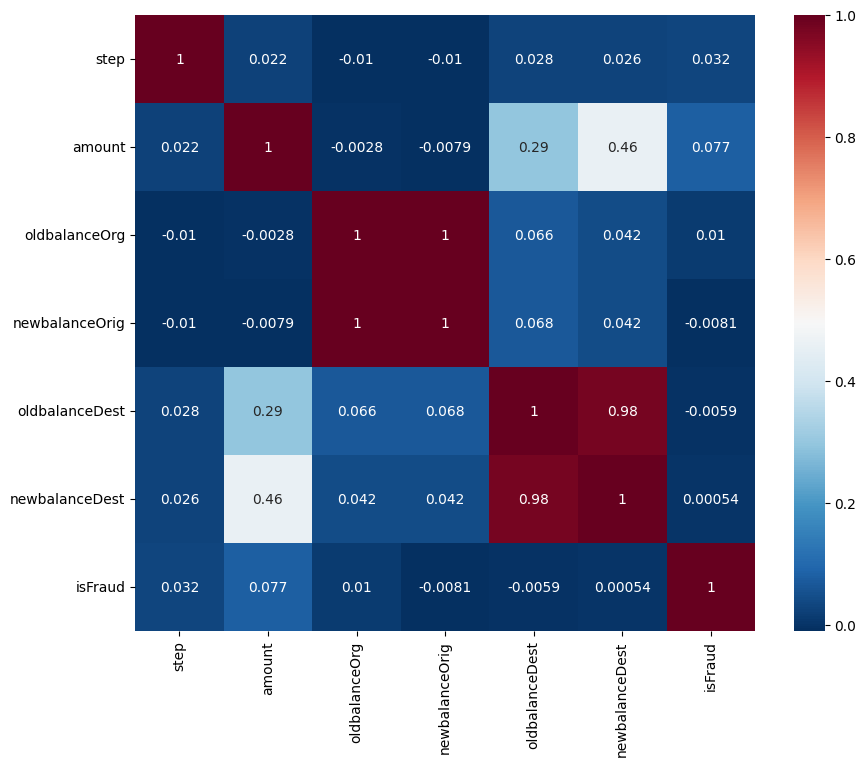

In [72]:
fig=plt.figure(figsize=(10,8))
corr=df_new.drop(columns=['type'],axis=1).corr('pearson')
sb.heatmap(corr,cmap='RdBu_r',annot=True)
plt.show()

we can see from the heatmap how features like nameOrig,oldbalanceOrgn,ewbalanceOrigf,nameDestoldbalanceDest,newbalanceDest

In [10]:
df_new["isFraud"].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

### Setup

In [12]:
X=df_new[(df_new['type']=='TRANSFER') | (df_new['type']=='CASH_OUT')]
#drop irrelevant features
X.head(10)

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
2,1,TRANSFER,181.00,181.00,0.0,0.0,0.00,1
3,1,CASH_OUT,181.00,181.00,0.0,21182.0,0.00,1
15,1,CASH_OUT,229133.94,15325.00,0.0,5083.0,51513.44,0
19,1,TRANSFER,215310.30,705.00,0.0,22425.0,0.00,0
24,1,TRANSFER,311685.89,10835.00,0.0,6267.0,2719172.89,0
42,1,CASH_OUT,110414.71,26845.41,0.0,288800.0,2415.16,0
47,1,CASH_OUT,56953.90,1942.02,0.0,70253.0,64106.18,0
48,1,CASH_OUT,5346.89,0.00,0.0,652637.0,6453430.91,0
51,1,CASH_OUT,23261.30,20411.53,0.0,25742.0,0.00,0
58,1,TRANSFER,62610.80,79114.00,16503.2,517.0,8383.29,0


In [13]:
Y=X["isFraud"]
del X["isFraud"]

In [14]:
import sklearn
from sklearn.preprocessing import LabelEncoder
lb=LabelEncoder()
X['type']=lb.fit_transform(X['type'])
X.head(10)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4488\1183589353.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['type']=lb.fit_transform(X['type'])


,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
2,1,1,181.00,181.00,0.0,0.0,0.00
3,1,0,181.00,181.00,0.0,21182.0,0.00
15,1,0,229133.94,15325.00,0.0,5083.0,51513.44
19,1,1,215310.30,705.00,0.0,22425.0,0.00
24,1,1,311685.89,10835.00,0.0,6267.0,2719172.89
42,1,0,110414.71,26845.41,0.0,288800.0,2415.16
47,1,0,56953.90,1942.02,0.0,70253.0,64106.18
48,1,0,5346.89,0.00,0.0,652637.0,6453430.91
51,1,0,23261.30,20411.53,0.0,25742.0,0.00
58,1,1,62610.80,79114.00,16503.2,517.0,8383.29


In [15]:
X.shape

(2770409, 7)

In [16]:
# training and test set
x,x_test,y,y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

#training and validation set
x_train,x_val,y_train,y_val=train_test_split(x,y,test_size=0.2,random_state=42)

In [17]:
x.shape

(2216327, 7)

In [18]:
print("x,y shape: {} {} ".format(x.shape,y.shape))
print("x,y train shape: {} {} ".format(x_train.shape,y_train.shape))
print("x,y test shape: {} {} ".format(x_test.shape,y_test.shape))
print("x,y val shape: {} {} ".format(x_val.shape,y_val.shape))


x,y shape: (2216327, 7) (2216327,) 
x,y train shape: (1773061, 7) (1773061,) 
x,y test shape: (554082, 7) (554082,) 
x,y val shape: (443266, 7) (443266,) 


### Fine Tune

#### Random Model vs Fine tuned Model

In [20]:
weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())
clf = XGBClassifier(max_depth = 3, scale_pos_weight = weights, \
                n_jobs = 4)

clf.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=4,
              num_parallel_tree=None, random_state=None, ...)

In [38]:
from sklearn.model_selection import GridSearchCV
clf_grid = XGBClassifier(scale_pos_weight = weights)
param_grid=[
    {"max_depth":[2,3,5],"n_jobs":[2,4,6]}
]
grid_search=GridSearchCV(clf_grid,param_grid,scoring="accuracy",cv=4,return_train_score=True)
grid_search.fit(x_train,y_train)

GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...e,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid=[{'max_depth': [2, 3, 5], 'n_jobs': [2, 4, 6]}],
             return_train_score=True, scoring='accuracy')

In [73]:
grid_search.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=2,
              num_parallel_tree=None, random_state=None, ...)

In [76]:
grid_search.best_params_

{'max_depth': 5, 'n_jobs': 2}

### Inference

In [26]:
Yval_pred=clf.predict(x_val)
pd.Series(Yval_pred).value_counts()

0    436582
1      6684
Name: count, dtype: int64

In [27]:
from sklearn.metrics import confusion_matrix,accuracy_score
cf1=accuracy_score(Yval_pred,y_val)
cf1

0.9877455072123736

In [28]:
Ytest_pred=clf.predict(x_test)
Ytest_pred

array([0, 0, 0, ..., 0, 0, 0])

In [30]:
from sklearn.metrics import confusion_matrix,accuracy_score
cf2=accuracy_score(Ytest_pred,y_test)
cf2

0.9876480376550764

In [40]:
clf_cv = XGBClassifier(max_depth = 5, scale_pos_weight = weights, \
                n_jobs = 2)

clf_cvz.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=2,
              num_parallel_tree=None, random_state=None, ...)

In [43]:
y_val_pred_cv=clf_cv.predict(x_val)
ac_cv=accuracy_score(y_val_pred_cv,y_val)
ac_cv

0.9958738094056391

### Conclusion

<p> (1) From above result we can see the fine tubed model outperforms the random model</p>
<p> (2) The search space during grid search could be big.
<p> (3) LazyPredict module(motivation for our use case) can be used to compare different models.